In [ ]:
!pip install --upgrade numpy pandas matplotlib scikit-learn

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The basics: Regression with `sklearn`

`sklearn` implements the [`LinearRegression()` class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) which fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

The class implements several methods which we will use to train and validate our model:
  - `.fit(X, y)`
  - `.score(X, y)`
  - `.predict(X)`
  
## Loading the data

In [ ]:
housing_data = pd.concat([
    pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"),
    pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
]).reset_index(drop=True)

housing_data.describe()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(housing_data, test_size=0.2)
train_df.head()

## Building a Linear Model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_mod = LinearRegression().fit(
    train_df['housing_median_age'].to_numpy().reshape(-1, 1),
    train_df['median_house_value']
)

lin_mod.coef_

### Scoring the model

The coefficient of determination $R^2$ is defined as $(1 - \frac{u}{v})$, where $u$ is the residual sum of squares `((y_true - y_true.mean()) ** 2).sum()` and $v$ is the total sum of squares `((y_true - y_true.mean()) ** 2).sum()`. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of `y`, disregarding the input features, would get an $R^2$ score of 0.0.

In [ ]:
r_squared = lin_mod.score(
    test_df['housing_median_age'].to_numpy().reshape(-1, 1),
    test_df['median_house_value']
)

print('R^2 = {:2.2%}'.format(r_squared))

-----

## Building a Multiple Linear Model

In [ ]:
lin_mod = LinearRegression().fit(
    train_df.loc[:, train_df.columns!='median_house_value'],
    train_df['median_house_value']
)

lin_mod.coef_

### Scoring the model

The coefficient of determination $R^2$ is defined as $(1 - \frac{u}{v})$, where $u$ is the residual sum of squares `((y_true - y_true.mean()) ** 2).sum()` and $v$ is the total sum of squares `((y_true - y_true.mean()) ** 2).sum()`. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of `y`, disregarding the input features, would get an $R^2$ score of 0.0.

In [ ]:
r_squared = lin_mod.score(
    test_df.loc[:, test_df.columns!='median_house_value'],
    test_df['median_house_value']
)

print('R^2 = {:2.2%}'.format(r_squared))

## Plot Residuals

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

y_pred = lin_mod.predict(test_df.loc[:, test_df.columns!='median_house_value'])
display = PredictionErrorDisplay(
    y_true=test_df['median_house_value'],
    y_pred=y_pred
)
display.plot()
plt.show()

## Normalize values

When creating a model with multiple features, the values of each feature should cover roughly the same range.  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should
normalize features in a multi-feature model.

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A **Z-score** is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

In [ ]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean) / train_df_std

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
train_df_norm.head()

In [ ]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_norm = (test_df - train_df_mean) / train_df_std

# Note that we transform the test data with the values calculated from the training set,
# as you should always transform your datasets with exactly the same values.

## Train a model with normalized values

In [ ]:
lin_mod = LinearRegression().fit(
    train_df_norm.loc[:, train_df_norm.columns!='median_house_value'],
    train_df_norm['median_house_value']
)
print(lin_mod.coef_)

r_squared = lin_mod.score(
    test_df_norm.loc[:, test_df_norm.columns!='median_house_value'],
    test_df_norm['median_house_value']
)

print('R^2 = {:2.2%}'.format(r_squared))

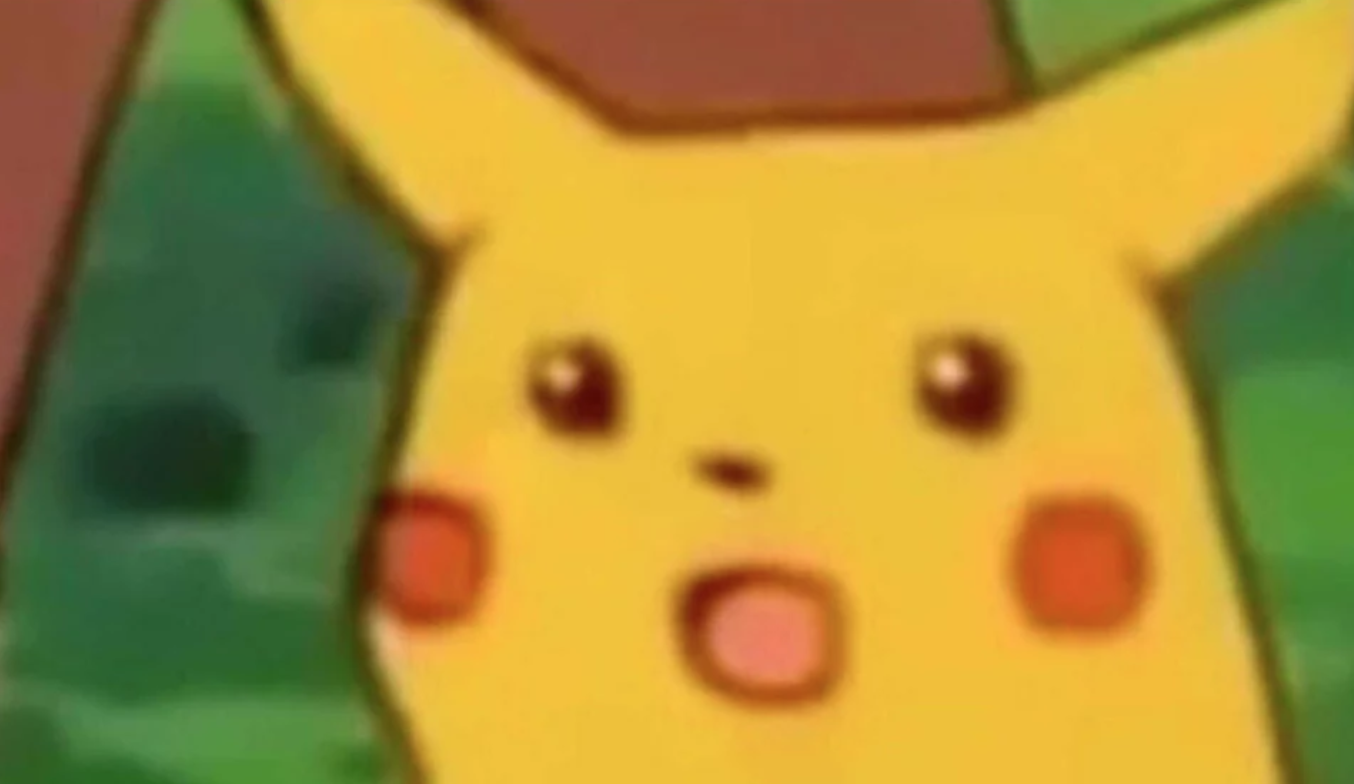

Surprise! R^2 is a correlation that's unit-invariant

-----

## Training a Binary Regression

In classification problems, the label for every example must be either 0 or 1. Unfortunately, the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of `median_house_values` contains floating-point values primarily between -3 and +3.

We want to create a new column named `median_house_value_is_high` in both the training set and the test set . If the `median_house_value` is higher than a certain arbitrary value (defined by `threshold`), then set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0.

In [ ]:
threshold = 1.0

train_df_norm['median_house_value_is_high'] = (train_df_norm["median_house_value"] > threshold).astype(float)
test_df_norm['median_house_value_is_high'] = (test_df_norm["median_house_value"] > threshold).astype(float)

In [ ]:
from sklearn.linear_model import LogisticRegression

logit_mod = LogisticRegression().fit(
    train_df_norm.loc[:, ~train_df_norm.columns.isin(['median_house_value', 'median_house_value_is_high'])],
    train_df_norm['median_house_value_is_high']
)

r_squared = logit_mod.score(
    test_df_norm.loc[:, ~test_df_norm.columns.isin(['median_house_value', 'median_house_value_is_high'])],
    test_df_norm['median_house_value_is_high']
)

print('R^2 = {:2.2%}'.format(r_squared))

## Evaluating our regressor

In [ ]:
from sklearn.metrics import roc_auc_score

predictions = logit_mod.predict_proba(
    test_df_norm.loc[:, ~test_df_norm.columns.isin([
        'median_house_value',
        'median_house_value_is_high'])]
)[:, 1]

roc_auc_score(
    test_df_norm['median_house_value_is_high'],
    predictions
)

In [ ]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_predictions(
    test_df_norm['median_house_value_is_high'],
    predictions,
    name=f"Predicted high house price",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under Curve")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = logit_mod.predict(
    test_df_norm.loc[:, ~test_df_norm.columns.isin([
        'median_house_value',
        'median_house_value_is_high'])]
)

cm = confusion_matrix(
    test_df_norm['median_house_value_is_high'],
    predictions,
    labels=logit_mod.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=logit_mod.classes_)

disp.plot()
plt.show()

-----

# Lab Exercise

Craigslist is the world's largest collection of used vehicles for sale. GitHub user [@AustinReese](https://github.com/AustinReese/UsedVehicleSearch) scraped Craigslist used car ads to create a dataset of 4.25 million listings. We will be using a subset of around 2 million of these listings.

For this lab, the challenge is to:
  - [ ] Determine which features to include in a model;
  - [ ] Dummy encode or one-hot encode any categorical feature columns;
  - [ ] Perform any data normalization and bucketizing that you believe is necessary;
  - [ ] Perform any data imputation to correct for missing values that you believe is necessary;
  - [ ] Check for outliers and remove any spurious records from the dataset;
  - [ ] Optionally create 1 or more new, engineered feature column(s);
  - [ ] Train a multiple regression to predict vehicle listing price;
  - [ ] Train a binary logistic regression to predict whether vehicle listing price will be greater than $24,500; and
  - [ ] Evaluate both of your models for accuracy

In [ ]:
data = pd.read_csv("https://cdn.c18l.org/vehicles_lab.csv")
data.head()